In [1]:
import numpy as np
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import dtnnlib as dtnn

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## Building 2D model

In [3]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

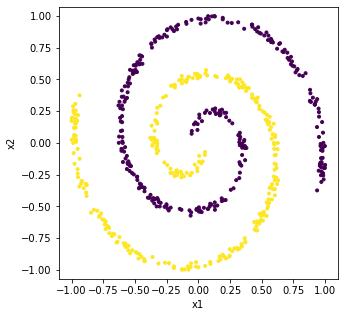

In [4]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [5]:
xx, yy = xx.to(device), yy.to(device)

## Distance Based Classification

In [227]:
class DistanceTransform_Epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
        nc = num_centers
        if epsilon is not None:
            nc += 1
        self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
#         self.scaler = nn.Parameter(torch.ones(1, 1)*1)

        self.bias = nn.Parameter(torch.ones(1, nc)*0) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        if self.epsilon is not None:
            dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        dists = -dists
#         dists = torch.exp(dists)
        dists = dists/np.sqrt(dists.shape[1])
#         dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True, unbiased=True))
#         dists = dists/torch.norm(dists, dim=1, keepdim=True)
        dists = dists*torch.exp(self.scaler)
        if self.bias is not None: dists = dists+self.bias
        return dists

In [228]:
class DT_epsilon_Classifier(DistanceTransform_Epsilon):
    
    def __init__(self, input_dim, output_dim, bias=True, epsilon=1.0):
        super().__init__(input_dim, output_dim, bias=bias, epsilon=epsilon)
        
    def forward(self, x):
        xo = super().forward(x)
#         return xo[:, :-1]
        return F.softmax(xo, dim=-1)

In [229]:
def log_nll_loss(output, target):
    return F.nll_loss(torch.log(output), target)

In [230]:
yy = yy.reshape(-1).type(torch.LongTensor)

#### DTeSM Residual 

In [231]:
class DTeSM(DistanceTransform_Epsilon):
    
    def __init__(self, input_dim, output_dim, bias=True, epsilon=1.0, itemp=10):
        ### NOTE: Here, not using bias leads to more uniform centroid activation, and easy to compare..
        super().__init__(input_dim, output_dim, bias=bias, epsilon=epsilon)
        
        self.scale_shift = dtnn.ScaleShift(-1, scaler_init=itemp, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
        self.temp_activ = None
        
    def forward(self, x):
        xo = super().forward(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        self.temp_activ = xo.data
#         return xo[:, :-1]
        return xo

In [232]:
class LocalMLP_DTeSM(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=None, itemp=1.0):
        super().__init__()
        self.layer0 = DTeSM(input_dim, hidden_dim, True, epsilon, itemp)
        if epsilon is not None:
            hidden_dim += 1
        self.layer1 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        return x

In [233]:
class LocalResidual_DTeSM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, epsilon=None, itemp=1.0):
        super().__init__()
        self.layer0 = DTeSM(input_dim, hidden_dim, True, epsilon, itemp)
        if epsilon is not None:
            hidden_dim += 1
        self.layer1 = nn.Linear(hidden_dim, input_dim)
        self.layer1.bias.data *= 0.
        
    def forward(self, x):
        h = self.layer0(x)
        h = x + self.layer1(h)
        return h

## Optimize Classifier to Data

In [234]:
# model = DT_epsilon_Classifier(2, 2, epsilon=1.0)
model = DT_epsilon_Classifier(2, 2, epsilon=None)

In [235]:
criterion = log_nll_loss

In [236]:
### ASSUMING: first half is class 0 and second half is class 1
cls_randidx = torch.randint(len(yy)//2, (2,))+torch.LongTensor([0, len(yy)//2])
model.centers.data = xx[cls_randidx]

In [237]:
yout = model(xx)
loss = criterion(yout, yy)

accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()                
print(f'Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

Acc:0.65, Loss:0.639694333076477


In [238]:
loss_bkp = float(loss)

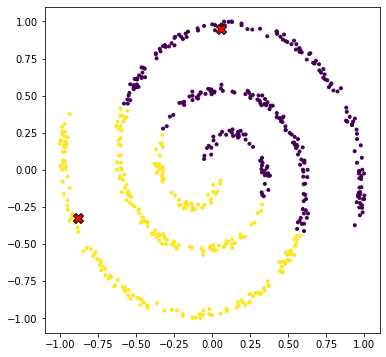

In [239]:
ax = plt.figure(figsize=(6,6)).add_subplot()
out = yout.max(dim=1)[1].data.cpu().numpy()
ax.scatter(x1, x2, c=out, marker= '.')
## plot centroids
c = model.centers.data.cpu()
ax.scatter(c[:,0], c[:,1], ec='k', fc='r', marker= 'X', s=100)
plt.show()

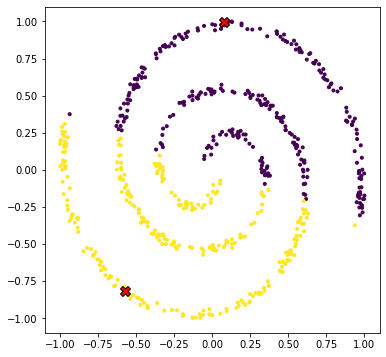

Acc:0.67, Loss:0.6320279240608215


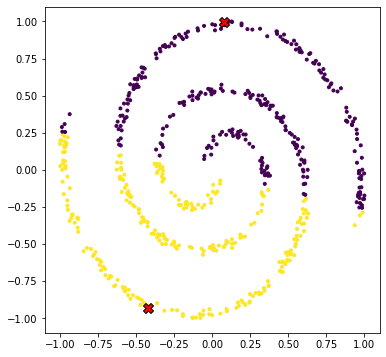

Acc:0.67, Loss:0.6313579082489014


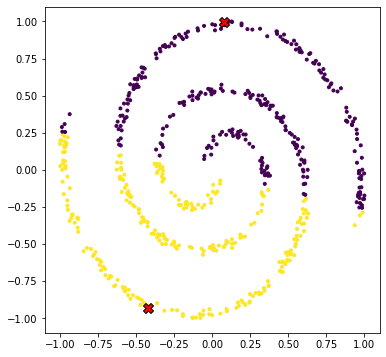

Acc:0.67, Loss:0.6313579082489014


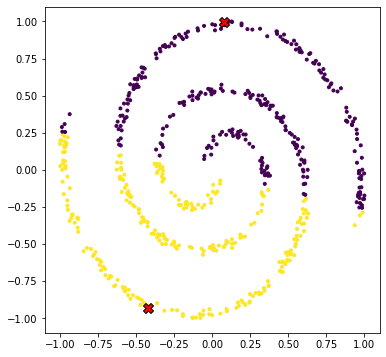

Acc:0.67, Loss:0.6313579082489014


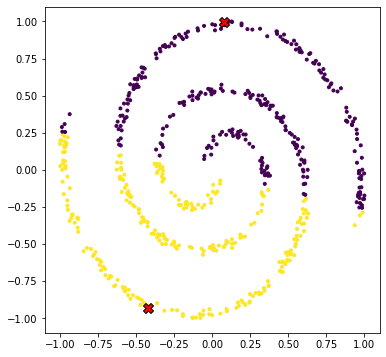

Acc:0.67, Loss:0.6313579082489014


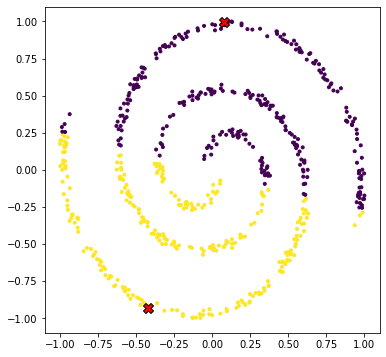

Acc:0.67, Loss:0.6313579082489014


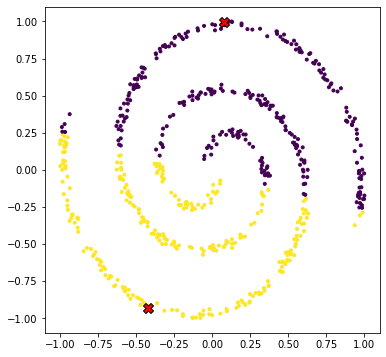

Acc:0.67, Loss:0.6313579082489014


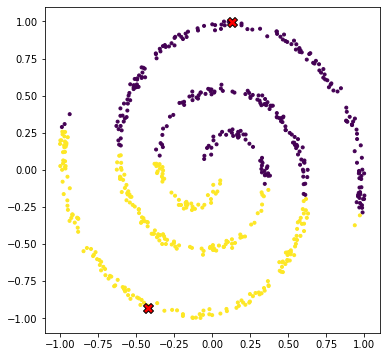

Acc:0.67, Loss:0.6313399076461792


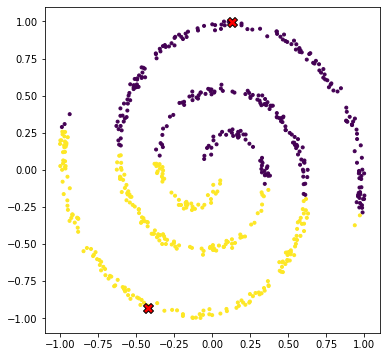

Acc:0.67, Loss:0.6313399076461792


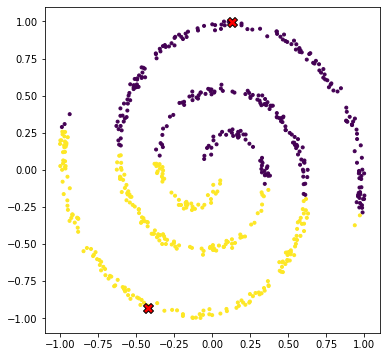

Acc:0.67, Loss:0.6313399076461792


In [240]:
#############################
### Development of replacing centers per class
STEPS = 100
for steps in range(STEPS):
    for i in range(2):## for each class
        backup_center = copy.deepcopy(model.centers.data)
        cls_randidx = torch.randint(len(yy)//2, (1,))[0] + i*len(yy)//2
        model.centers.data[i] = xx[cls_randidx]

        yout = model(xx)
        loss = criterion(yout, yy)
        accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()                
#         print(f'Acc:{float(accuracy):.2f}, Loss:{float(loss)}')
        if loss > loss_bkp:
            model.centers.data = backup_center
        else:
            loss_bkp = float(loss)
        
    if (steps+1)%10 == 0:
        yout = model(xx)
        loss = criterion(yout, yy)
        accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()                
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = yout.max(dim=1)[1].data.cpu().numpy()
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], ec='k', fc='r', marker= 'X', s=100)
        plt.show()
        print(f'Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

In [241]:
num_points = 1000
X1 = np.linspace(-1.5, 1.5, num_points)*2
X2 = np.linspace(-1.5, 1.5, num_points)*2
X1, X2 = np.meshgrid(X1, X2)

XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)
XX.shape

torch.Size([1000000, 2])

### Repeat below after changing parameters

In [250]:
YY = model(XX)
YY = YY.reshape(num_points, num_points, -1)

In [251]:
yout = model(xx)
out = yout.max(dim=1)[1].data.cpu().numpy()
accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()
accuracy

tensor(0.6733)

In [252]:
max_actv = model(model.centers.data).data.cpu()
max_actv = max_actv.diag().numpy()
max_actv

array([0.9999721, 0.9999721], dtype=float32)

center: 0.9999721 max_grid: 0.9999721 True


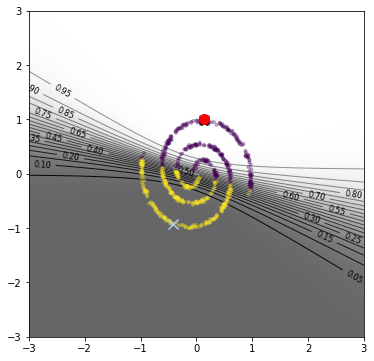

center: 0.9999721 max_grid: 0.9999721 True


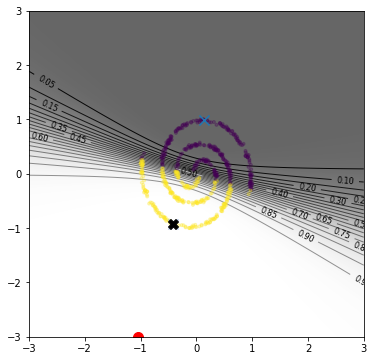

In [253]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    c = model.centers.data.cpu()
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv[idx],"max_grid:",conf.max(), max_actv[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

In [254]:
model.bias.data, model.scaler, torch.exp(model.scaler)

(tensor([[0., 0.]]), Parameter containing:
 tensor([[2.]], requires_grad=True), tensor([[7.3891]], grad_fn=<ExpBackward>))

##### Changing parameters

In [248]:
# model.bias.data[0] = torch.Tensor([0, 0, -1])

In [255]:
model.scaler.data[0,0] = 2.

In [256]:
classifier = model

## Optimize Local Res-MLP center noisy

In [257]:
### If we update the inputs to reduce the loss, it would be clustering of either classes to respective centers
### In this case, we may directly pick the centers of classifier as target of each point in the input space.

In [258]:
tt_0 = classifier.centers.data[yy]
tt_0

tensor([[ 0.1301,  0.9965],
        [ 0.1301,  0.9965],
        [ 0.1301,  0.9965],
        ...,
        [-0.4244, -0.9322],
        [-0.4244, -0.9322],
        [-0.4244, -0.9322]])

In [369]:
H0 = 20
N_search0 = 4

In [370]:
residual0 = LocalResidual_DTeSM(2, H0, epsilon=0.5, itemp=3.0)

In [371]:
residual0.layer1.weight.data[:, -1] = residual0.layer1.weight.data[:, -1]*0 ### zero out epsilon..

In [372]:
residual0

LocalResidual_DTeSM(
  (layer0): DTeSM(
    (scale_shift): ScaleShift()
    (softmax): Softmax(dim=-1)
  )
  (layer1): Linear(in_features=21, out_features=2, bias=True)
)

In [373]:
residual0.layer1.bias.data

tensor([-0., 0.])

In [374]:
## random init
randidx = torch.randperm(len(xx))[:H0]
residual0.layer0.centers.data = xx[randidx] 

diff = tt_0[randidx] - residual0.layer0.centers.data - residual0.layer1.bias.data
residual0.layer1.weight.data[:, :H0] = diff.t()

In [375]:
#### Visualize neurons -- code below 

[Visualize Neurons (jump to code)](#Visualize-Neurons)

In [38]:
asdasdasd

NameError: name 'asdasdasd' is not defined

### Add Neurons

In [379]:
def add_neurons_to_residual(model, centers, values):
    c = torch.cat((model.layer0.centers.data, centers), dim=0)
    if model.layer0.epsilon is None:
        v = torch.cat((model.layer1.weight.data, values.t()), dim=1)
        s = torch.cat([model.layer0.bias.data, torch.ones(1, len(centers))*0], dim=1)
    else:
        v = torch.cat((model.layer1.weight.data[:,:-1], values.t(), model.layer1.weight.data[:,-1:]), dim=1)
        s = torch.cat([model.layer0.bias.data[:,:-1], torch.ones(1, len(centers))*0, model.layer0.bias.data[:,-1:]], dim=1)
        
    model.layer0.centers.data = c
    model.layer1.weight.data = v
    model.layer0.bias.data = s
    pass

In [380]:
randidx = torch.randperm(len(xx))[:N_search0]

In [381]:
shift_by = tt_0[randidx] - xx[randidx] - residual0.layer1.bias.data
add_neurons_to_residual(residual0, xx[randidx], shift_by)

In [382]:
with torch.no_grad():
    h1 = residual0(xx)
    yout = classifier(h1)
accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()
accuracy

tensor(0.8617)

[Visualize Neurons (jump to code)](#Visualize-Neurons)

### Prune Neurons

In [383]:
def remove_neurons_from_residual(model, importance, num_prune):
    N = model.layer0.centers.shape[0]
    importance = importance[:N]
    topk_idx = torch.topk(importance, k=N-num_prune, largest=True)[1]
    removing = torch.topk(importance, k=num_prune, largest=False)[1]
    print(f"Removing:\n{removing.data.sort()[0]}")
    
    c = model.layer0.centers.data[topk_idx]
    ## modifying for value tensor and bias (for epsilon value)
    if model.layer0.epsilon is not None:
        topk_idx = torch.cat([topk_idx, torch.tensor([N], dtype=topk_idx.dtype)])
    s = model.layer0.bias.data[:,topk_idx]
    v = model.layer1.weight.data[:,topk_idx]
    model.layer0.centers.data = c
    model.layer1.weight.data = v
    model.layer0.bias.data = s
    pass

In [384]:
class ImportanceEstimator:
    
    def __init__(self, module):
        self.module = module
        self.outputs = None
        self.gradients = None
        self.back_hook = None
        self.forw_hook = None
        self.significance = None
        self.reset_significance()
        
    def reset_significance(self):
        _N = self.module.centers.shape[0]
        if self.module.epsilon is not None:
            _N += 1
        self.significance = torch.zeros(_N)
        
    def accumulate_significance(self):
        with torch.no_grad():
            self.significance += torch.sum((self.outputs*self.gradients)**2, dim=0)
        
    def capture_outputs(self, module, inp, out):
        self.outputs = out.data.cpu()

    def capture_gradients(self, module, gradi, grado):
        self.gradients = grado[0].data.cpu()
        
    def attach_hook(self):
        self.forw_hook = self.module.softmax.register_forward_hook(self.capture_outputs)
        self.back_hook = self.module.softmax.register_backward_hook(self.capture_gradients)
        
    def remove_hook(self):
        self.back_hook.remove()
        self.forw_hook.remove()

In [385]:
def none_grad(model):
    for p in model.parameters():
        p.grad = None

In [386]:
imp_est = ImportanceEstimator(residual0.layer0)

In [387]:
mse_loss = nn.MSELoss()

In [388]:
none_grad(residual0)

imp_est.attach_hook()
h1 = residual0(xx)
h1.register_hook(lambda grad: grad/torch.norm(grad, dim=1, keepdim=True))
####################################
#         grad = torch.randn_like(yout)
#         yout.backward(gradient=grad)
###################################
mse_loss(h1, tt_0).backward()
imp_est.accumulate_significance()

imp_est.remove_hook()

In [389]:
imp_est.significance

tensor([27.2408,  8.5187,  1.5954,  6.0155,  7.7777,  2.3239,  1.5209, 30.0946,
         1.4796,  1.9024,  0.6771,  0.3778,  2.2187, 26.8821, 15.3642, 16.4240,
         2.3300, 14.1005, 21.9220,  1.4785,  6.1582, 24.7831,  4.1400,  4.6098,
         0.0000])

In [390]:
remove_neurons_from_residual(residual0, imp_est.significance, N_search0)

Removing:
tensor([ 8, 10, 11, 19])


In [391]:
with torch.no_grad():
    h1 = residual0(xx)
    yout = classifier(h1)
accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()
accuracy

tensor(0.8117)

In [392]:
print(yout.shape)

torch.Size([600, 2])


### Optimize Iteratively

In [431]:
STEPS = 10
for step in range(STEPS):
    ## Add
    randidx = torch.randperm(len(xx))[:N_search0]
    shift_by = tt_0[randidx] - xx[randidx] - residual0.layer1.bias.data
    add_neurons_to_residual(residual0, xx[randidx], shift_by)
    with torch.no_grad():
        h1 = residual0(xx)
        yout = classifier(h1)
    accuracy_add = (yout.max(dim=1)[1] == yy).type(torch.float).mean()
    
    ## Prune
    none_grad(residual0)
    imp_est.reset_significance()
    imp_est.attach_hook()
    
    h1 = residual0(xx)
    h1.register_hook(lambda grad: grad/torch.norm(grad, dim=1, keepdim=True))
    ####################################
#     grad = torch.randn_like(h1)
#     h1.backward(gradient=grad)
    ###################################
    mse_loss(h1, tt_0).backward()
#     log_nll_loss(classifier(h1), yy).backward()

    ###################################
    imp_est.accumulate_significance()
    imp_est.remove_hook()
    
    remove_neurons_from_residual(residual0, imp_est.significance, N_search0)
    with torch.no_grad():
        h1 = residual0(xx)
        yout = classifier(h1)
        loss = criterion(yout, yy)
    accuracy_prune = (yout.max(dim=1)[1] == yy).type(torch.float).mean()
    
    print(f'Step:{step}, AccAdd:{float(accuracy_add):.2f}, Acc:{float(accuracy_prune):.2f}, Loss:{float(loss):.3f}')

Removing:
tensor([ 6, 18, 19, 20])
Step:0, AccAdd:0.80, Acc:0.75, Loss:1.295
Removing:
tensor([ 9, 10, 19, 22])
Step:1, AccAdd:0.75, Acc:0.71, Loss:1.796
Removing:
tensor([12, 15, 22, 23])
Step:2, AccAdd:0.74, Acc:0.74, Loss:1.669
Removing:
tensor([16, 17, 20, 21])
Step:3, AccAdd:0.73, Acc:0.69, Loss:2.261
Removing:
tensor([11, 16, 17, 22])
Step:4, AccAdd:0.76, Acc:0.71, Loss:2.162
Removing:
tensor([ 9, 20, 21, 23])
Step:5, AccAdd:0.81, Acc:0.71, Loss:2.164
Removing:
tensor([ 4, 18, 22, 23])
Step:6, AccAdd:0.71, Acc:0.68, Loss:2.367
Removing:
tensor([ 9, 15, 21, 22])
Step:7, AccAdd:0.74, Acc:0.71, Loss:1.922
Removing:
tensor([ 2, 20, 21, 22])
Step:8, AccAdd:0.81, Acc:0.81, Loss:1.356
Removing:
tensor([11, 12, 20, 23])
Step:9, AccAdd:0.84, Acc:0.76, Loss:1.279


In [406]:
imp_est.significance

tensor([29.0018, 30.2743,  4.2815, 18.1429, 19.2062, 18.3563, 24.2542,  7.5867,
        19.9892, 12.6119, 14.8959, 10.2130, 10.8154, 12.4948, 10.3069, 10.1009,
         8.5352, 14.5029,  3.8622,  7.2935,  0.8770,  5.3503,  8.0519,  2.5238,
         0.0000])

In [201]:
"""
If two neurons are similar, both of their importance goes down, 
                            and hence both are removed... not preserving proper parameters..
 --> Instead of random neuron selection, sample neurons from maximum error neurons (or mix&match)..
 --> Check if addition of certain neuron decrease maximum_activation of other neurons.. 
         (or if neurons should lie outside epsilon/2 of existing neurons)
 --> Pruning only one neuron at a time helps overcome similar neurons getting pruned (for LocalMLP)...
         
Also: The temperature, scale and epsilon should be optimized in order for neuron-selection to work.


"""
print()

### Visualize Neurons

In [407]:
h1 = residual0(xx)
yout = classifier(h1)
out = yout.max(dim=1)[1].data.cpu().numpy()
## centroids and shift
c = residual0.layer0.centers.data.cpu()
d = residual0.layer1.weight.data.cpu().t() #+ .cpu()

In [408]:
accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()
accuracy

tensor(0.9183)

In [409]:
max_actv = residual0.layer0(residual0.layer0.centers.data).data.cpu()
max_actv = max_actv.diag()#.numpy()
max_actv

tensor([1.0000, 0.9992, 0.9983, 0.9979, 0.9955, 0.9954, 0.6882, 0.9934, 0.9993,
        0.9881, 0.9997, 0.9998, 0.6629, 0.9988, 0.9863, 0.6880, 0.9891, 0.6619,
        0.9999, 0.9927])

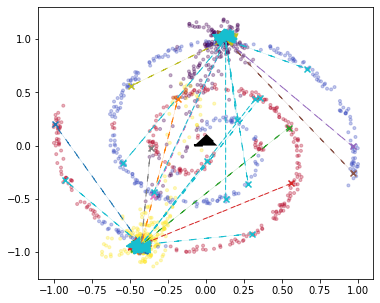

In [410]:
ax = plt.figure(figsize=(6,5)).add_subplot()
ax.scatter(h1.data[:,0], h1.data[:,1], c=yy, marker= '.', alpha=0.3)

ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3, cmap="coolwarm")

for i in range(c.shape[0]):
    color = matplotlib.cm.tab10(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
color = "k"
ax.arrow(0, 0, d[len(c),0], d[len(c),1], head_width=0.15, head_length=0.1, fc="k", ec="k", linestyle=(0, (5, 10)), linewidth=2.0)
    
plt.show()

In [411]:
residual0.layer0.bias.data, residual0.layer0.scaler, torch.exp(residual0.layer0.scaler)

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 Parameter containing:
 tensor([[3.]], requires_grad=True),
 tensor([[20.0855]], grad_fn=<ExpBackward>))

#### Visualize residual-layer neuron's activation region

In [412]:
residual0(XX)
YY = residual0.layer0.temp_activ
YY = YY.reshape(num_points, num_points, -1)
YY.shape

torch.Size([1000, 1000, 21])

In [413]:
max_actv = residual0.layer0(residual0.layer0.centers.data).data.cpu().diag()
max_actv_ = max_actv.numpy()
max_actv_

array([0.99996793, 0.99917966, 0.99827325, 0.99786013, 0.99545825,
       0.99540234, 0.68817246, 0.993367  , 0.9992893 , 0.9881143 ,
       0.99966145, 0.999811  , 0.6629494 , 0.99880457, 0.9863128 ,
       0.68801117, 0.9890838 , 0.6619081 , 0.999853  , 0.9927233 ],
      dtype=float32)

center: 0.99991477 max_grid: 0.99991226 True


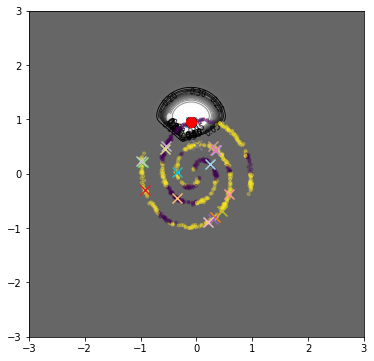

center: 0.5226338 max_grid: 0.5216614 True


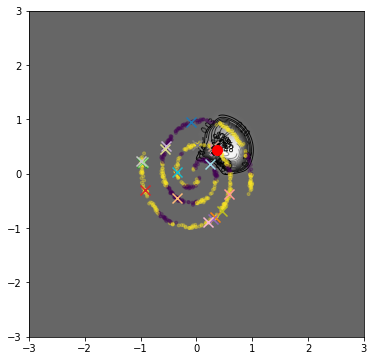

center: 0.701949 max_grid: 0.69673795 True


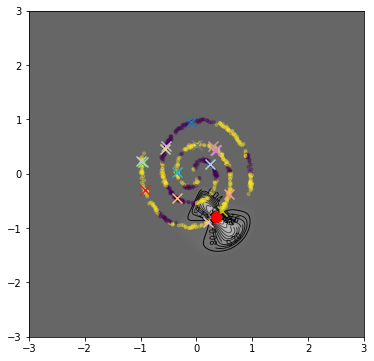

center: 0.99992776 max_grid: 0.9999249 True


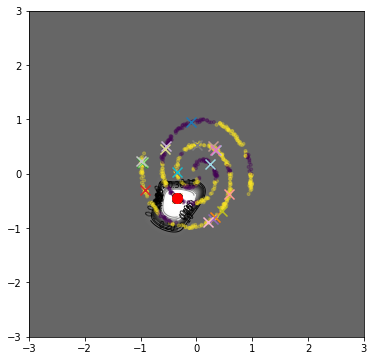

center: 0.5566019 max_grid: 0.55316406 True


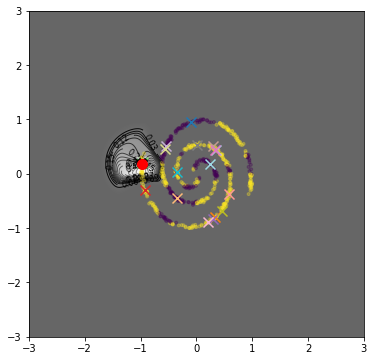

center: 0.52912045 max_grid: 0.5242201 True


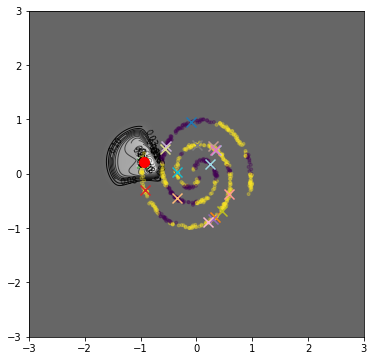

center: 0.9999429 max_grid: 0.9999392 True


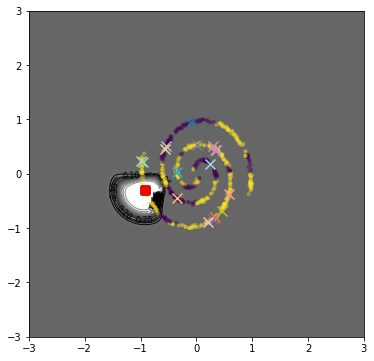

center: 0.9994916 max_grid: 0.9994874 True


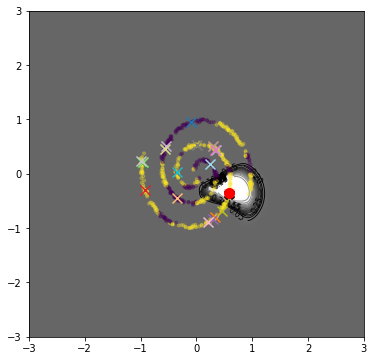

center: 0.6911539 max_grid: 0.68397486 True


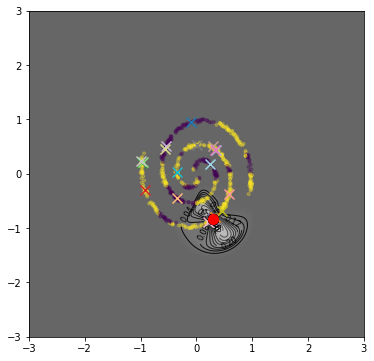

center: 0.8294089 max_grid: 0.829392 True


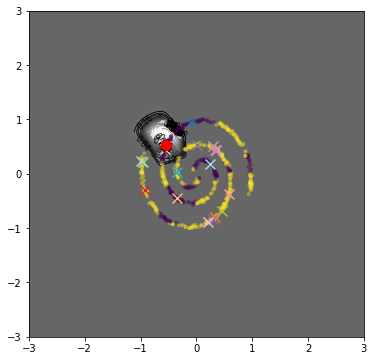

center: 0.616107 max_grid: 0.61603695 True


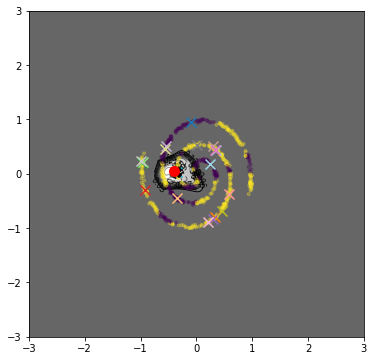

center: 0.72780967 max_grid: 0.72693694 True


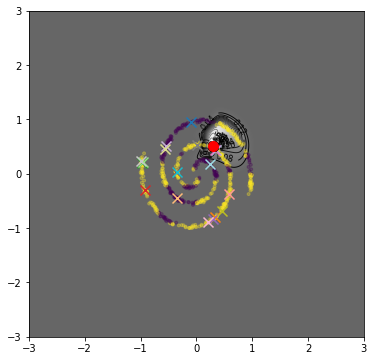

center: 0.5101495 max_grid: 0.5015628 True


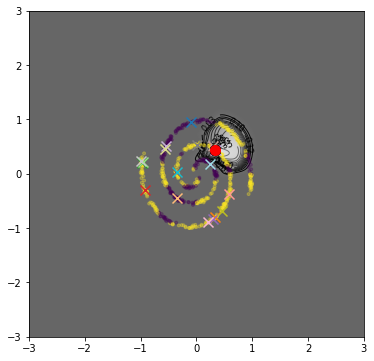

center: 0.9151664 max_grid: 0.9151472 True


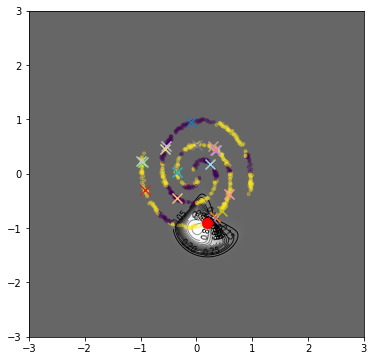

center: 0.9970663 max_grid: 0.9970018 True


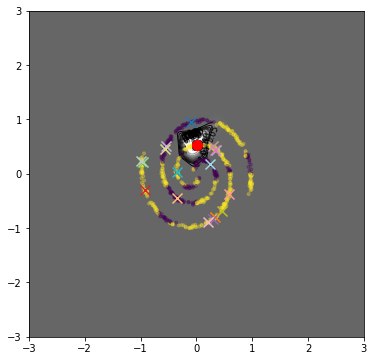

center: 0.5730776 max_grid: 0.57108575 True


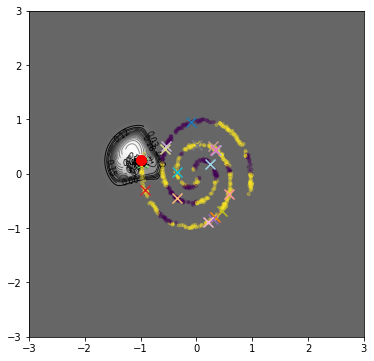

center: 0.9574552 max_grid: 0.9575114 False


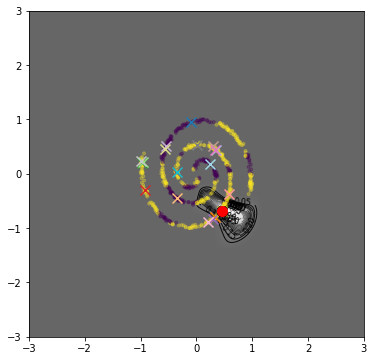

center: 0.8293159 max_grid: 0.82927644 True


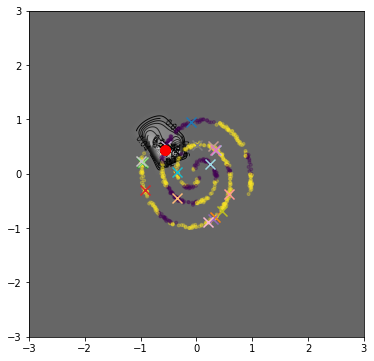

center: 0.6161126 max_grid: 0.61608195 True


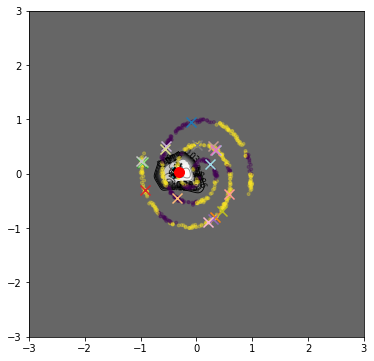

center: 0.99516016 max_grid: 0.9951525 True


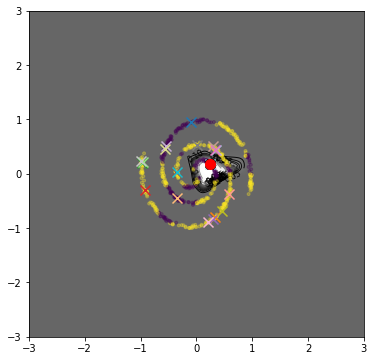

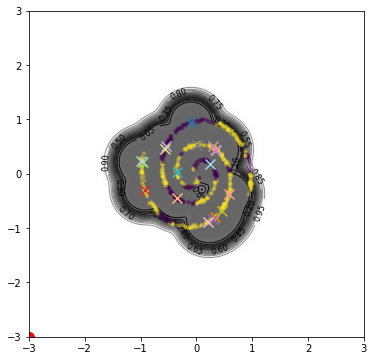

In [286]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv_[idx],"max_grid:",conf.max(), max_actv_[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

In [287]:
residual0.layer0.scaler, torch.exp(residual0.layer0.scaler), residual0.layer0.bias

(Parameter containing:
 tensor([[3.]], requires_grad=True),
 tensor([[20.0855]], grad_fn=<ExpBackward>),
 Parameter containing:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
        requires_grad=True))

In [288]:
residual0.layer0.scale_shift.scaler, residual0.layer0.epsilon

(5.0, 0.5)

In [376]:
residual0.layer0.epsilon = 0.5

In [377]:
residual0.layer0.scaler.data[0,0] = 3.0

In [378]:
residual0.layer0.scale_shift.scaler = 5.0

## Train 2layer LocalMLP with noisy method

In [432]:
H0 = 20
N_search0 = 1

model = LocalMLP_DTeSM(2, H0, 2, epsilon=0.5, itemp=7.)

In [433]:
model.layer0.scaler.data[0,0] = 2.0

In [434]:
model.layer1.weight.data[:, -1] = model.layer1.weight.data[:, -1]*0

In [435]:
## random init
randidx = torch.randperm(len(xx))[:H0]
model.layer0.centers.data = xx[randidx] 
yy_0 = yy[randidx]
tt_0 = torch.zeros(H0, 2)
for i in range(len(tt_0)):
    tt_0[i, yy_0[i]] = 1.
model.layer1.weight.data[:, :H0] = tt_0.t()

In [436]:
randidx

tensor([280,  23, 428, 535, 559, 384, 288,  25, 345, 341, 381, 364, 166, 231,
        133, 408, 346, 462, 515, 392])

In [437]:
model(xx).shape

torch.Size([600, 2])

In [438]:
with torch.no_grad():
    yout = model(xx)
accuracy = (yout.max(dim=1)[1] == yy).type(torch.float).mean()
accuracy

tensor(0.7883)

## Visualize mlp layer

In [471]:
model(XX)
YY = model.layer0.temp_activ
YY = YY.reshape(num_points, num_points, -1)
YY.shape

torch.Size([1000, 1000, 21])

In [472]:
out = yout.max(dim=1)[1].data.cpu().numpy()
## centroids and shift
c = model.layer0.centers.data.cpu()
# d = model.layer1.weight.data.cpu().t() #+ .cpu()

In [473]:
max_actv = model.layer0(model.layer0.centers.data).data.cpu().diag()
max_actv_ = max_actv.numpy()
max_actv_

array([0.9844849 , 0.9840247 , 0.92909837, 0.9829381 , 0.9157557 ,
       0.9306602 , 0.9783927 , 0.98573893, 0.9476893 , 0.97928977,
       0.89050716, 0.9191777 , 0.89956266, 0.919505  , 0.9568542 ,
       0.9335356 , 0.97238344, 0.98252904, 0.9604961 , 0.96935093],
      dtype=float32)

center: 0.9844849 max_grid: 0.98417586 True


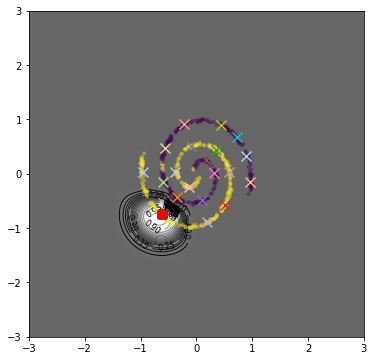

center: 0.9840247 max_grid: 0.98377347 True


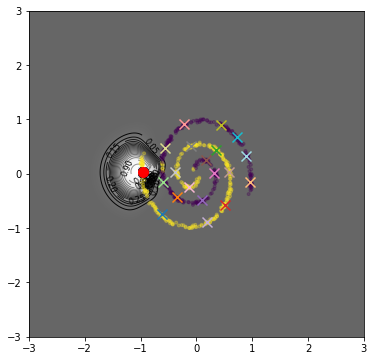

center: 0.92909837 max_grid: 0.9278053 True


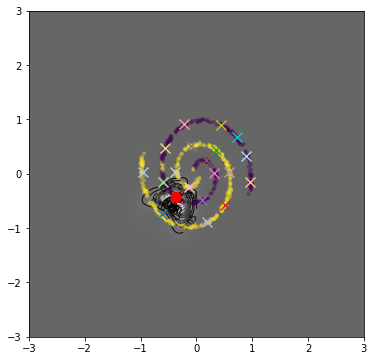

center: 0.9829381 max_grid: 0.98263353 True


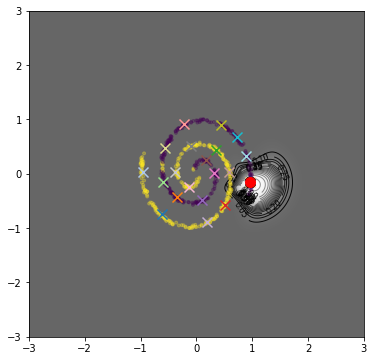

center: 0.9157557 max_grid: 0.91403306 True


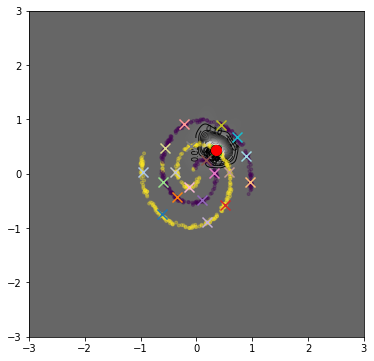

center: 0.9306602 max_grid: 0.92921424 True


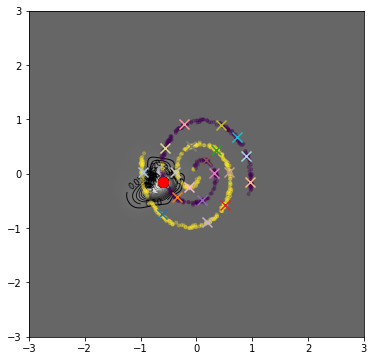

center: 0.9783927 max_grid: 0.97775567 True


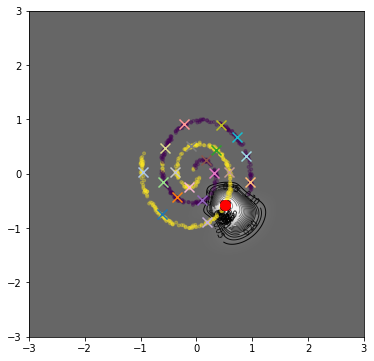

center: 0.98573893 max_grid: 0.9854643 True


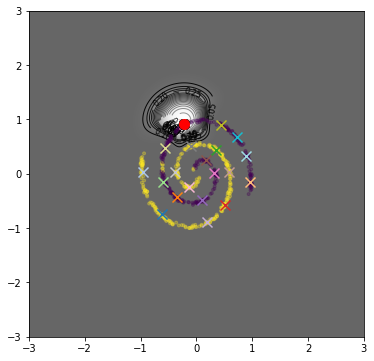

center: 0.9476893 max_grid: 0.9463015 True


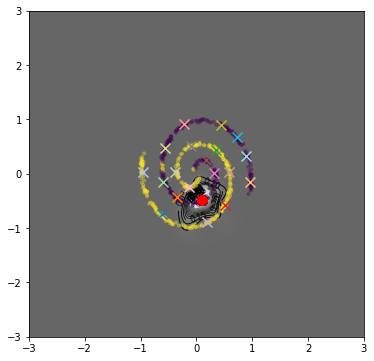

center: 0.97928977 max_grid: 0.9788346 True


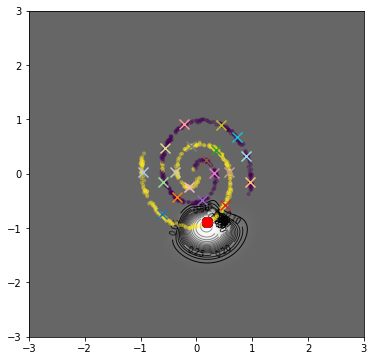

center: 0.89050716 max_grid: 0.8893621 True


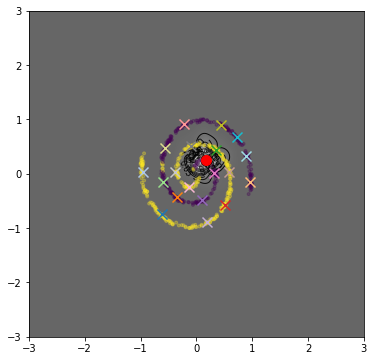

center: 0.9191777 max_grid: 0.91829586 True


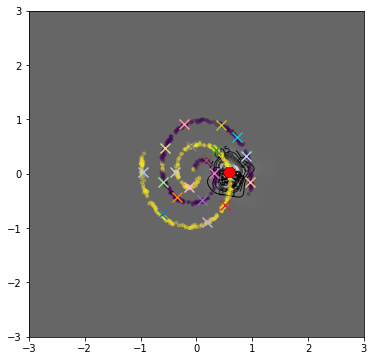

center: 0.89956266 max_grid: 0.89811504 True


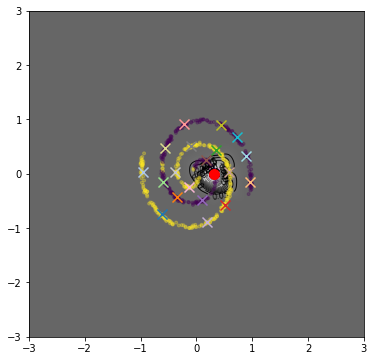

center: 0.919505 max_grid: 0.9194006 True


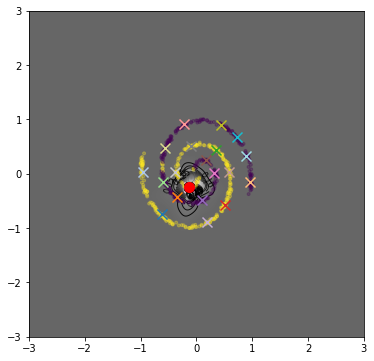

center: 0.9568542 max_grid: 0.9557712 True


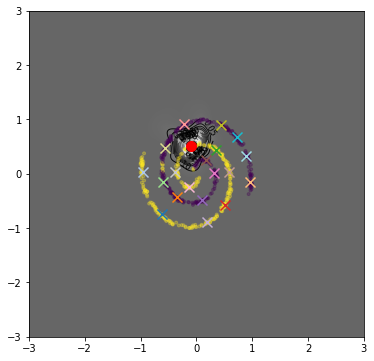

center: 0.9335356 max_grid: 0.931465 True


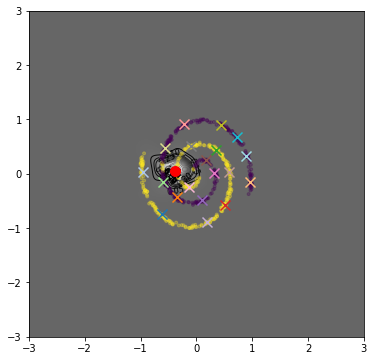

center: 0.97238344 max_grid: 0.9723023 True


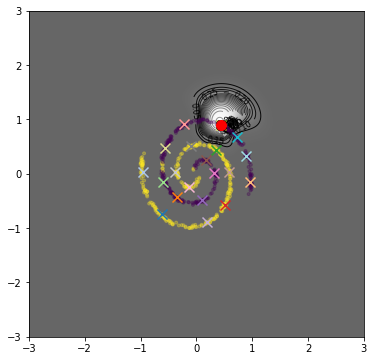

center: 0.98252904 max_grid: 0.9819581 True


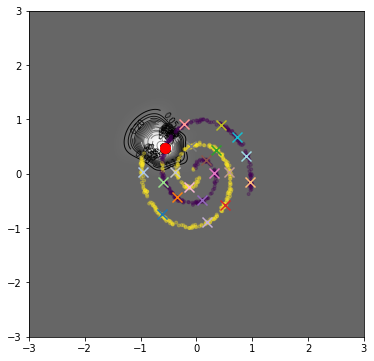

center: 0.9604961 max_grid: 0.9592183 True


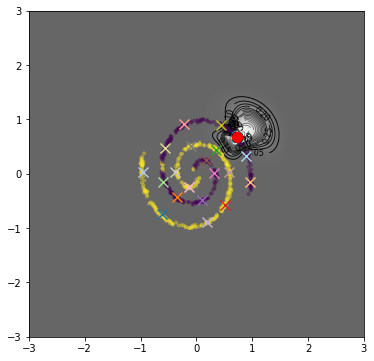

center: 0.96935093 max_grid: 0.96841085 True


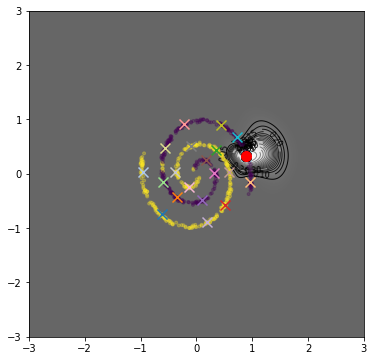

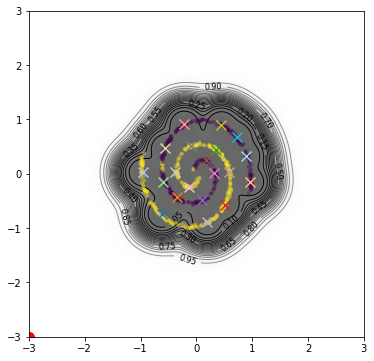

In [474]:
for idx in range(YY.shape[-1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    
    ax = plt.figure(figsize=(6,6)).add_subplot()
    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
        print(f"center:",max_actv_[idx],"max_grid:",conf.max(), max_actv_[idx] >= conf.max())
    except:
        pass
    
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     LVLs = torch.linspace(0.0, 0.99, 20)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1, zorder=-2)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    plt.show()

## Add and Prune

In [446]:
criterion = nn.CrossEntropyLoss()

In [447]:
imp_est = ImportanceEstimator(model.layer0)

In [469]:
STEPS = 10
for step in range(STEPS):
    ## Add
    randidx = torch.randperm(len(xx))[:N_search0]
    yy_0 = yy[randidx]
    tt_0 = torch.zeros(len(yy_0), 2)
    for i in range(len(yy_0)):
        tt_0[i, yy_0[i]] = 1.
    add_neurons_to_residual(model, xx[randidx], tt_0)
    with torch.no_grad():
        yout = model(xx)
    accuracy_add = (yout.max(dim=1)[1] == yy).type(torch.float).mean()
    
    ## Prune
    none_grad(model)
    imp_est.reset_significance()
    imp_est.attach_hook()
    
    yout = model(xx)
#     yout.register_hook(lambda grad: grad/torch.norm(grad, dim=1, keepdim=True))
    ####################################
#     grad = torch.randn_like(yout)
#     yout.backward(gradient=grad)
    ###################################
    criterion(yout, yy).backward()
    ###################################
    imp_est.accumulate_significance()
    imp_est.remove_hook()
    
    remove_neurons_from_residual(model, imp_est.significance, N_search0)
    with torch.no_grad():
        yout = model(xx)
        loss = criterion(yout, yy)
    accuracy_prune = (yout.max(dim=1)[1] == yy).type(torch.float).mean()
    
    print(f'Step:{step}, AccAdd:{float(accuracy_add):.2f}, Acc:{float(accuracy_prune):.2f}, Loss:{float(loss):.3f}')

Removing:
tensor([20])
Step:0, AccAdd:0.97, Acc:0.97, Loss:0.393
Removing:
tensor([20])
Step:1, AccAdd:0.97, Acc:0.97, Loss:0.393
Removing:
tensor([20])
Step:2, AccAdd:0.97, Acc:0.97, Loss:0.393
Removing:
tensor([20])
Step:3, AccAdd:0.97, Acc:0.97, Loss:0.393
Removing:
tensor([4])
Step:4, AccAdd:0.98, Acc:0.99, Loss:0.389
Removing:
tensor([11])
Step:5, AccAdd:0.99, Acc:0.99, Loss:0.389
Removing:
tensor([20])
Step:6, AccAdd:0.99, Acc:0.99, Loss:0.389
Removing:
tensor([20])
Step:7, AccAdd:0.99, Acc:0.99, Loss:0.389
Removing:
tensor([20])
Step:8, AccAdd:0.99, Acc:0.99, Loss:0.389
Removing:
tensor([20])
Step:9, AccAdd:1.00, Acc:0.99, Loss:0.389


In [470]:
imp_est.significance

tensor([4.0482e-06, 7.2088e-06, 7.1369e-06, 5.8520e-06, 6.0685e-06, 5.8656e-06,
        5.8475e-06, 5.7810e-06, 5.2640e-06, 5.2291e-06, 5.2060e-06, 4.3845e-06,
        4.9886e-06, 4.9772e-06, 4.6609e-06, 5.7614e-06, 4.0894e-06, 3.4327e-06,
        3.3532e-06, 6.3745e-06, 2.6151e-06, 0.0000e+00])